In [292]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind
import bz2
import json

In [356]:
# Choose MLB or NBA
df = pd.read_csv("refined_csvs/5_enhanced.csv")
# df = pd.read_csv("nba/data/nba_bets_2.csv")

df.dropna(subset=["synth_home_bid", "synth_home_ask"], inplace=True)
df.sort_values(by="date", inplace=True)
df["num_home_trades"] = df["home_trades"].str.len()
df["num_away_trades"] = df["away_trades"].str.len()

In [357]:
def add_dog_pnl_inplace(df):
    df["underdog_pnl"] = np.where(
        df["synth_home_bid"] > 0.5,
        df["synth_home_bid"] - df["home_win"],
        0
    ) + np.where(
        df["synth_home_ask"] < 0.5,
        df["home_win"] - df["synth_home_ask"],
        0
    ) 
    df["favourite_pnl"] = np.where(
        df["synth_home_bid"] > 0.5,
        df["home_win"] - df["synth_home_ask"],
        0
    ) + np.where(
        df["synth_home_ask"] < 0.5,
        df["synth_home_bid"] - df["home_win"],
        0
    ) 

In [358]:
add_dog_pnl_inplace(df)

# 1. The filesize "arb"

In [359]:
df["log_fz"] = np.log(df["filesize"])

In [329]:
df.drop([2097, 2024, 3028, 3144], inplace=True) # (only for NBA, deleting two outliers - just too big!!)

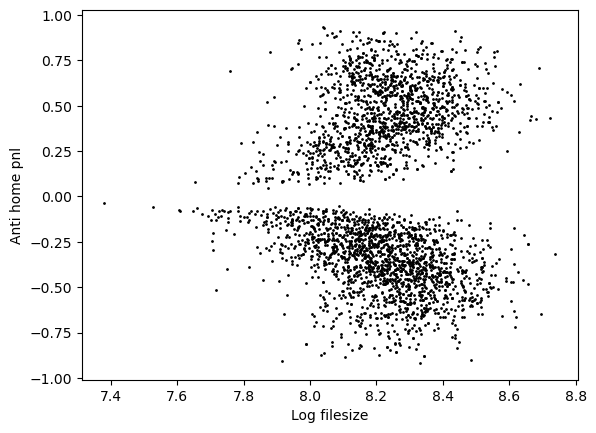

In [330]:
fig, ax = plt.subplots()
ax.scatter(df["log_fz"], df["anti_home_pnl"], s=1, color="black")
ax.set_xlabel("Log filesize")
ax.set_ylabel("Anti home pnl")
plt.show()

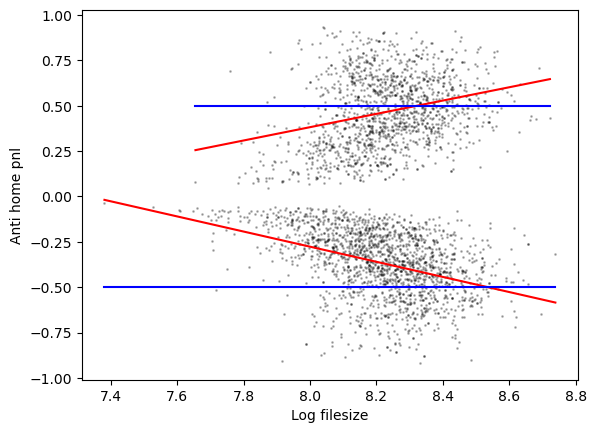

In [331]:
wins = df[df["anti_home_pnl"] > 0]
losses = df[df["anti_home_pnl"] < 0]
fig, ax = plt.subplots()
ax.scatter(df["log_fz"], df["anti_home_pnl"], s=1, color="black", alpha=0.25)
for sub_df, sign in zip([wins, losses], [1, -1]):
    pred, targ = sub_df["log_fz"], sub_df["anti_home_pnl"]
    beta = pred.cov(targ) / pred.var()
    cept = targ.mean() - beta * pred.mean()
    ax.plot(
        [pred.min(), pred.max()], 
        [cept + beta * pred.min(), cept + beta * pred.max()], 
        color="red"
    )
    ax.plot(
        [sub_df["log_fz"].min(), sub_df["log_fz"].max()], 
        [sign * 0.5, sign * 0.5], 
        color="blue"
    )
ax.set_xlabel("Log filesize")
ax.set_ylabel("Anti home pnl")
plt.show()

In [165]:
def get_t_p_for_sub_df(sub_df):
    pred, targ = sub_df["log_fz"], sub_df["anti_home_pnl"]
    b1_hat = pred.cov(targ) / pred.var()
    b0_hat = targ.mean() - b1_hat * pred.mean()
    residuals = targ - (b0_hat + b1_hat * pred)
    denom = (len(sub_df) - 2) * pred.var() * (len(sub_df) - 1)
    stderr = ((residuals ** 2).sum() / denom) ** 0.5
    tstat = (b1_hat / stderr).item()
    pvalue = t.sf(tstat, len(sub_df) - 2) if tstat > 0 else t.sf(-tstat, len(sub_df) - 2)
    return tstat, pvalue

In [332]:
tstat, pvalue = get_t_p_for_sub_df(wins)
print(f"Wins: t = {tstat:.3f}, pvalue = {pvalue:.3e}")
tstat, pvalue = get_t_p_for_sub_df(losses)
print(f"Losses: t = {tstat:.3f}, pvalue = {pvalue:.3e}")

Wins: t = 10.990, pvalue = 2.612e-27
Losses: t = -18.285, pvalue = 7.378e-69


In [333]:
df["log_fz"].corr(df["anti_home_pnl"]).item()

0.004591407488158005

In [334]:
df["log_fz"].corr(df["underdog_pnl"]).item()

0.10457705730395567

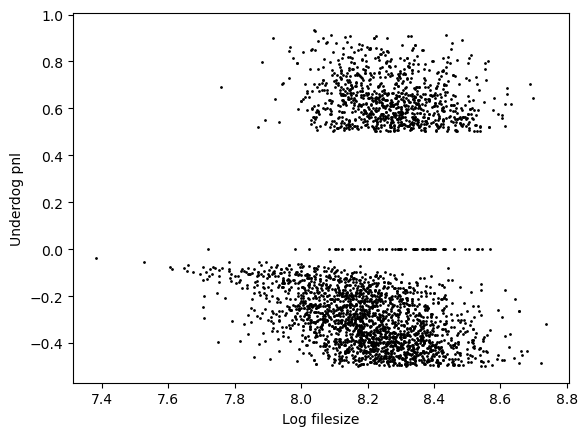

In [335]:
fig, ax = plt.subplots()
ax.scatter(df["log_fz"], df["underdog_pnl"], s=1, color="black")
ax.set_xlabel("Log filesize")
ax.set_ylabel("Underdog pnl")
plt.show()

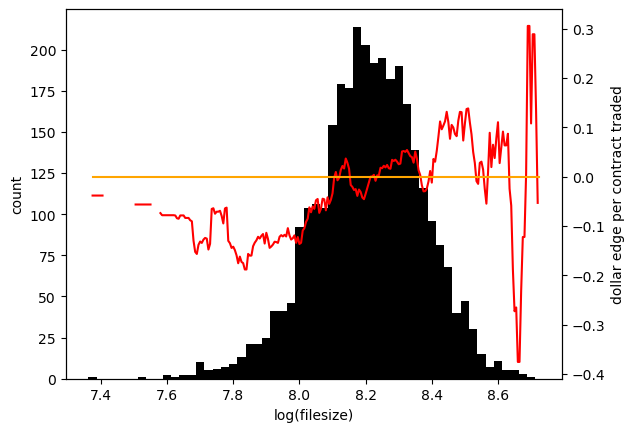

In [336]:
bin_width = 0.025

# Make histogram showing density
discretised = (df["log_fz"] / bin_width).astype(int) * bin_width
fig, ax = plt.subplots()
ax.hist(
    discretised, 
    bins=np.arange(discretised.min() - bin_width / 2, discretised.max() + bin_width / 2, bin_width), 
    color="black"
)
ax.set_ylabel("count")
ax.set_xlabel("log(filesize)")

# Make line showing pnl for the surrounding area
twin_ax = ax.twinx()
centres = np.arange(discretised.min(), discretised.max(), bin_width / 5)
radius = bin_width
bucket_pnls = [
    df[abs(df["log_fz"] - centre) < radius]["underdog_pnl"].mean()
    for centre in centres
]
twin_ax.plot(centres, bucket_pnls, color="red")
twin_ax.plot([discretised.min(), discretised.max()], [0, 0], color="orange")
twin_ax.set_ylabel("dollar edge per contract traded")

plt.show()

In [337]:
und_wins = df[df["underdog_pnl"] > 0]["log_fz"]
und_losses = df[df["underdog_pnl"] < 0]["log_fz"]
tstat, pvalue = ttest_ind(und_wins, und_losses)
print(tstat, pvalue)

11.900376566875837 5.73769669196831e-32


In [338]:
teams = list(df["home"].unique())
rows = []
for team in teams:
    team_df = df[df["name"].str.contains(team)]
    corr = team_df["log_fz"].corr(team_df["underdog_pnl"]).item()
    und_wins = team_df[team_df["underdog_pnl"] > 0]["log_fz"]
    und_losses = team_df[team_df["underdog_pnl"] < 0]["log_fz"]
    tstat, pvalue = ttest_ind(und_wins, und_losses)
    rows.append([corr, tstat, pvalue])
summ_df = pd.DataFrame(rows, columns=["corr", "tstat", "pvalue"], index=teams)
summ_df.sort_values(by="pvalue")

,corr,tstat,pvalue
Utah Jazz,0.239603,5.493663,1.137825e-07
Boston Celtics,0.208302,4.775042,3.456646e-06
Memphis Grizzlies,0.196532,4.747663,3.928268e-06
Houston Rockets,0.230136,4.209720,3.764379e-05
Orlando Magic,0.185531,4.012501,8.501326e-05
New York Knicks,0.174983,3.947381,1.087219e-04
Detroit Pistons,0.160624,3.897218,1.299895e-04
Philadelphia 76ers,0.149963,3.892513,1.337835e-04
Portland Trail Blazers,0.110798,3.709705,2.644806e-04
Chicago Bulls,0.168612,3.542090,4.899696e-04


In [173]:
def get_puzz_plot(filesz_df, team, ax, bin_width):
    team_df = filesz_df[filesz_df["name"].str.contains(team)]
    twin_ax = ax.twinx()
    ax.set_title(team)
    discretised = (team_df["log_fz"] / bin_width).astype(int) * bin_width
    twin_ax.hist(
        discretised, 
        bins=np.arange(discretised.min() - bin_width / 2, discretised.max() + bin_width / 2, bin_width), 
        color="black", alpha=0.4
    )
    
    # Make hist to show where the data is
    centres = np.arange(discretised.min(), discretised.max(), bin_width / 5)
    radius = bin_width
    bucket_pnls = [
        team_df[abs(team_df["log_fz"] - centre) < radius]["underdog_pnl"].mean()
        if len(team_df[abs(team_df["log_fz"] - centre) < radius]) > 10 else np.nan # i.e., silence noise
        for centre in centres
    ]
    ax.plot(centres, bucket_pnls, color="red")
    ax.plot([discretised.min(), discretised.max()], [0, 0], color="orange")

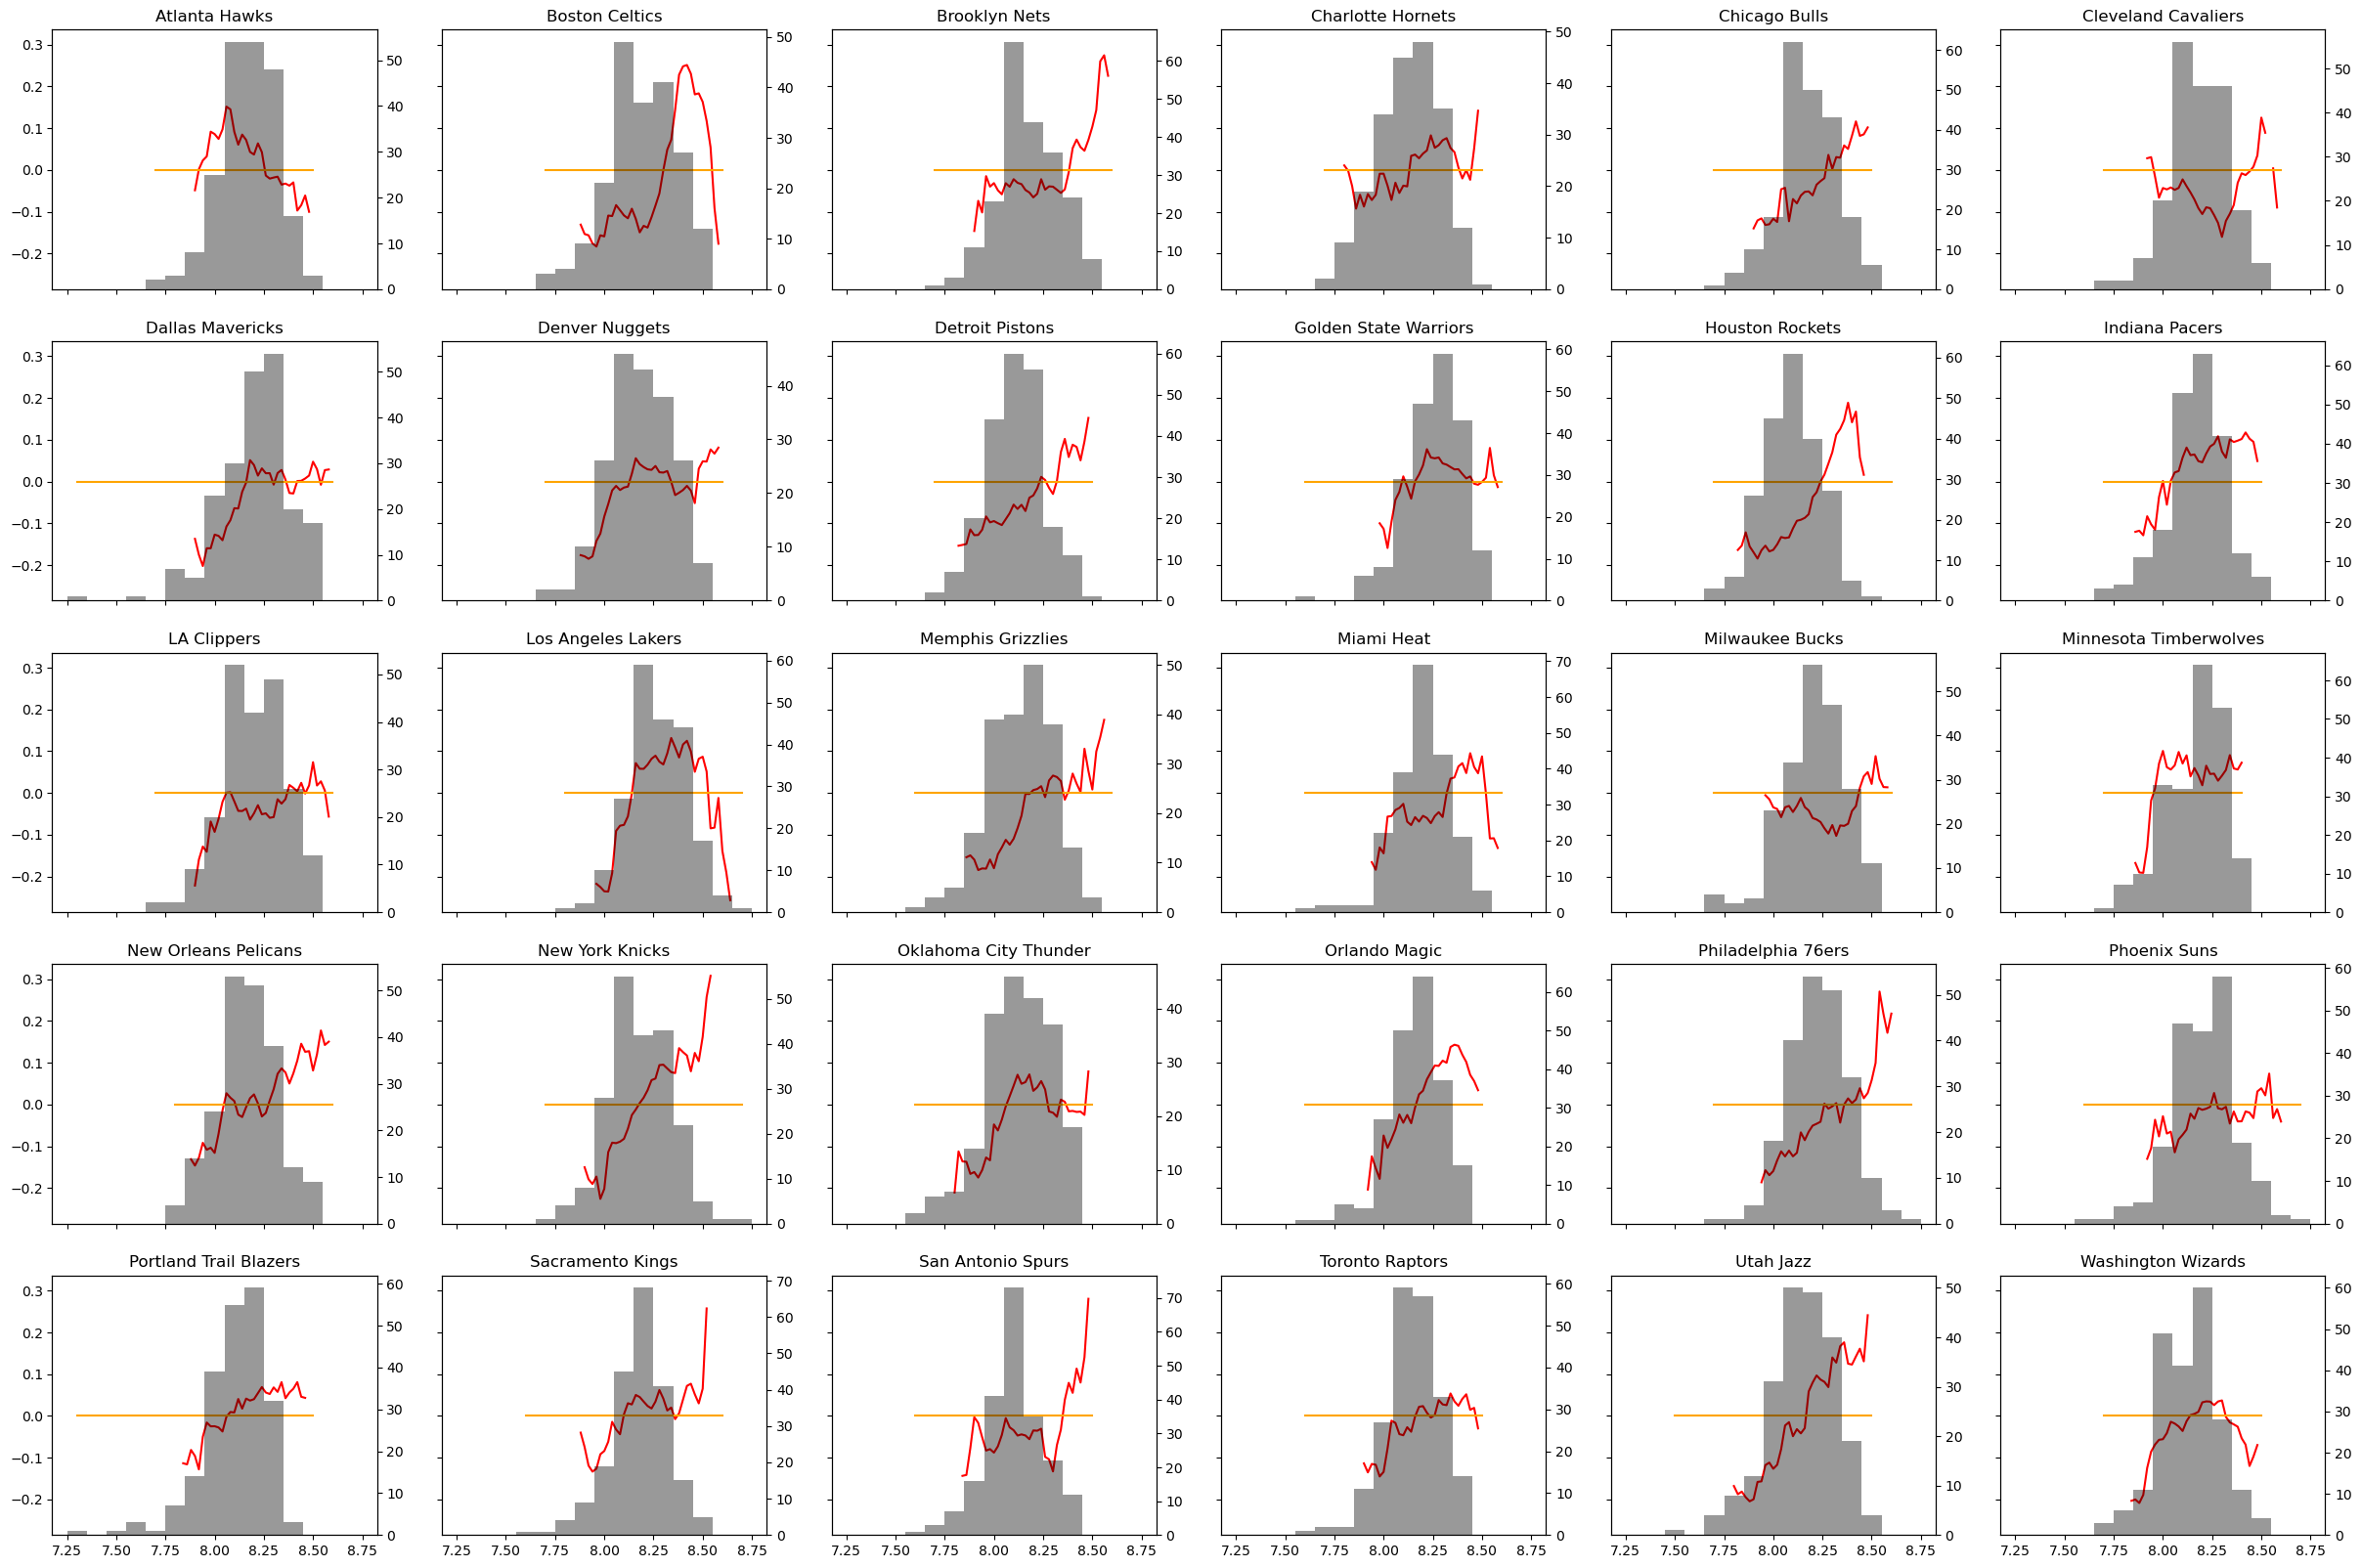

In [340]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(30, 20), sharex=True, sharey=True)
teams = df["home"].unique()
for team, axis in zip(sorted(teams), ax.flatten()):
    get_puzz_plot(df, team, axis, 0.1)
plt.show()

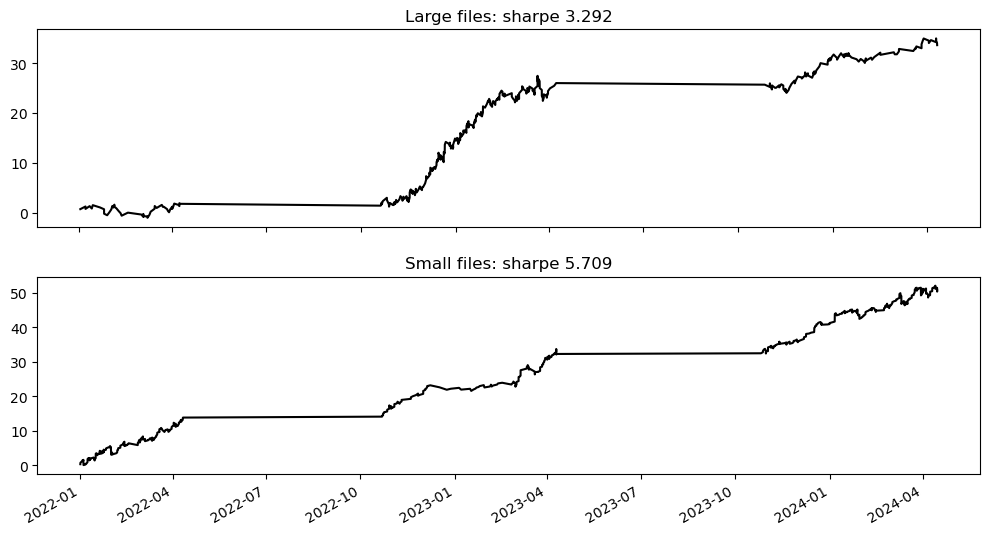

In [341]:
# MLB numbers
# low_cutoff, high_cutoff = 7.4, 7.6

# NBA numbers
low_cutoff, high_cutoff = 8.1, 8.4

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))

large_fz = df[df["log_fz"] > high_cutoff].sort_values(by="game_time")
ax[0].plot(
    pd.to_datetime(large_fz["game_time"]),
    large_fz["underdog_pnl"].cumsum(),
    color="black"
)
pnl = large_fz["underdog_pnl"]
sharpe = pnl.sum() / (pnl ** 2).sum() ** 0.5
ax[0].set_title(f"Large files: sharpe {sharpe:.3f}")

small_fz = df[df["log_fz"] < low_cutoff].sort_values(by="game_time")
ax[1].plot(
    pd.to_datetime(small_fz["game_time"]),
    small_fz["favourite_pnl"].cumsum(),
    color="black"
)
pnl = small_fz["favourite_pnl"]
sharpe = pnl.sum() / (pnl ** 2).sum() ** 0.5
ax[1].set_title(f"Small files: sharpe {sharpe:.3f}")

plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

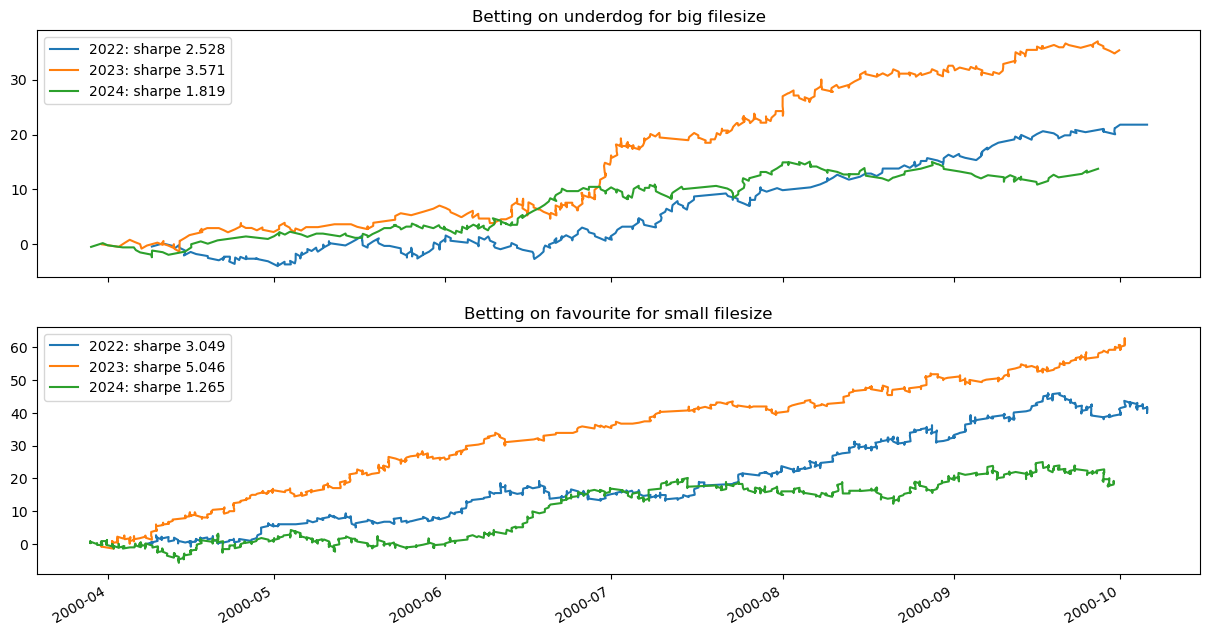

In [291]:
years = [2022, 2023, 2024]
# This cell doesn't work for NBA, which has season span the new year

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), sharex=True)
for curr_df, dog, i in zip([large_fz, small_fz], ["underdog", "favourite"], [0, 1]):
    sharpes = []
    for year in years:
        year_df = curr_df[curr_df["game_time"].astype(str).str[:4] == str(year)].sort_values(by="date")
        pnl = year_df[f"{dog}_pnl"]
        ax[i].plot(pd.to_datetime(year_df["date_mod_year"]), pnl.cumsum())
        sharpe = pnl.sum() / (pnl ** 2).sum() ** 0.5
        sharpes.append(sharpe)
    ax[i].legend([f"{year}: sharpe {sharpe:.3f}" for year, sharpe in zip(years, sharpes)])
ax[0].set_title("Betting on underdog for big filesize")
ax[1].set_title("Betting on favourite for small filesize")
plt.gcf().autofmt_xdate()
plt.show()

In [134]:
total_pnl = pd.concat([large_fz["underdog_pnl"], small_fz["favourite_pnl"]])
def get_sharpe(s): return s.sum() / (s ** 2).sum() ** 0.5
print(f"Sharpe: {get_sharpe(total_pnl):.3f}")

Sharpe: 6.065


In [135]:
# COPYPASTED from mlb notebook
def bz2_to_json(filepath):
    content_string = bz2.open(filepath, "rt", encoding="utf-8").read()
    # Instead of a bunch of dicts printed one after the other
    # Reshape so it's a list of dicts
    fixed_string = "[" + content_string.replace("}\n{", "},{") + "]"
    return json.loads(fixed_string)

def get_ingame_trade_nums(filename):
    data = bz2_to_json(filename)
    in_game = False
    home_trade_count, away_trade_count = 0, 0
    runners = data[0]["mc"][0]["marketDefinition"]["runners"]
    away_id, home_id = runners[0]["id"], runners[1]["id"]
    for line in data[2:]:
        if ("rc" in line["mc"][0]) and in_game:
            for trade in line["mc"][0]["rc"]:
                if trade["id"] == home_id:
                    home_trade_count += 1
                elif trade["id"] == away_id:
                    away_trade_count += 1
        try:
            if line["mc"][0]["marketDefinition"]["turnInPlayEnabled"]:
                in_game = True
        except KeyError:
            pass
    
    return {
        "num_home_ingame_trades": home_trade_count,
        "num_away_ingame_trades": away_trade_count
    }

In [342]:
ingame_trade_df = pd.DataFrame(list(df["filepath"].apply(get_ingame_trade_nums)))

In [343]:
df = pd.concat([df, ingame_trade_df], axis=1).dropna()

In [344]:
df["total_pregame"] = df["num_home_trades"] + df["num_away_trades"]
df["total_ingame"] = df["num_home_ingame_trades"] + df["num_away_ingame_trades"]

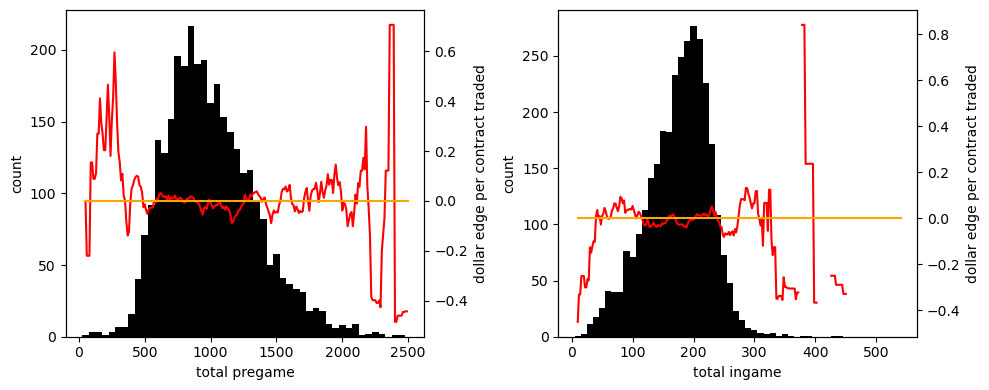

In [345]:
def make_complicated_plot(ax, df, prefix, bin_width):
    discretised = (df[f"total_{prefix}game"] / bin_width).astype(int) * bin_width
    ax.hist(
        discretised, 
        bins=np.arange(discretised.min() - bin_width / 2, discretised.max() + bin_width / 2, bin_width), 
        color="black"
    )
    ax.set_ylabel("count")
    ax.set_xlabel(f"total {prefix}game")
    
    # Make line showing pnl for the surrounding area
    twin_ax = ax.twinx()
    centres = np.arange(discretised.min(), discretised.max(), bin_width / 5)
    radius = bin_width
    bucket_pnls = [
        df[abs(df[f"total_{prefix}game"] - centre) < radius]["underdog_pnl"].mean()
        for centre in centres
    ]
    twin_ax.plot(centres, bucket_pnls, color="red")
    twin_ax.plot([discretised.min(), discretised.max()], [0, 0], color="orange")
    twin_ax.set_ylabel("dollar edge per contract traded")


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i, period, bin_width in zip(range(2), ["pre", "in"], [50, 10]):
    make_complicated_plot(ax[i], df, period, bin_width)
plt.tight_layout()
plt.show()


plt.show()

In [353]:
get_sharpe(df[df["total_pregame"] > 1650]["underdog_pnl"])

np.float64(-0.1790608545370685)

UPDATE: exact same for NBA too

# 2. Fixing it up

Still, there is probably something to be made of imbalances between home and away trades before the game starts. Let's have a look: 

In [360]:
df["home_minus_away"] = df["num_home_trades"] - df["num_away_trades"]
df["home_divby_away"] = np.log(df["num_home_trades"]) - np.log(df["num_away_trades"])
# Look, I know I said "divided", but that gives nasty scale
# Taking the log of that is the most natural thing one could do

Not sure if difference is relevant (because if it's small imbalance the model traders will absorb that) or ratio (because that is dimensionless and invariant under rescaling). Also going to try a hybrid, which is taking log of number plus some baseline, and tune that baseline, which should be nice hybrid. 

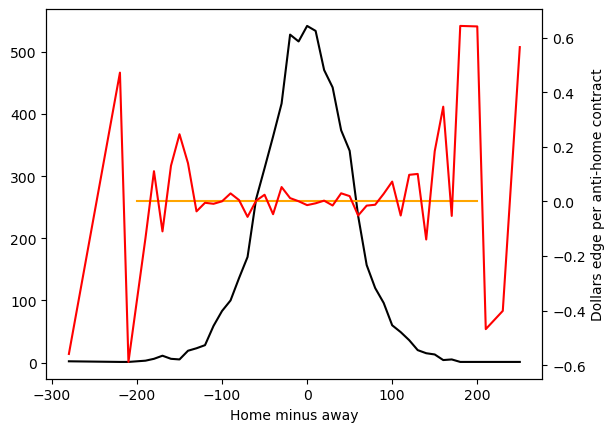

In [361]:
grid = 10
gridded = np.round(df["home_minus_away"] // grid) * grid
fig, ax = plt.subplots()
ax.plot(df.groupby(gridded)["home_minus_away"].count(), color="black")
ax_2 = ax.twinx()
ax_2.plot([-200, 200], [0, 0], color="orange")
ax_2.plot(df.groupby(gridded)["anti_home_pnl"].mean(), color="red")
ax.set_xlabel("Home minus away")
ax_2.set_ylabel("Dollars edge per anti-home contract")
plt.show()

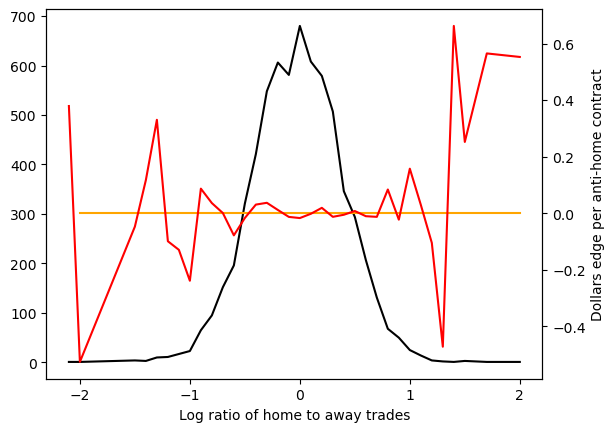

In [362]:
grid = 0.1
gridded = np.round(df["home_divby_away"] // grid) * grid
fig, ax = plt.subplots()
ax.plot(df.groupby(gridded)["home_divby_away"].count(), color="black")
ax_2 = ax.twinx()
ax_2.plot([-2, 2], [0, 0], color="orange")
ax_2.plot(df.groupby(gridded)["anti_home_pnl"].mean(), color="red")
ax.set_xlabel("Log ratio of home to away trades")
ax_2.set_ylabel("Dollars edge per anti-home contract")
plt.show()

Looks like when there is more betting in the home team market, the anti-home bet gets better, and vice versa for betting on away and pro-home. Let's do some parameter searching. NOTE: for NBA, you don't get the sort of imbalance you see in the baseball. 

In [250]:
def param_tune_plot_inplace(ax, direction, increment, method):
    # Direction is pro or anti, method is home_minus_away or home_divby_away
    xticks = np.arange(-20 * increment, 20 * increment + 0.001, increment)
    if direction == "anti":
        yticks = [
            get_sharpe(df[df[method] > threshold]["anti_home_pnl"])
            for threshold in xticks
        ]
    else:
        yticks = [
            get_sharpe(df[df[method] < threshold]["pro_home_pnl"])
            for threshold in xticks
        ]
    ax.plot(xticks, yticks, color="black")
    ax.set_title(f"{method}: {direction}")
    ax.set_ylabel("Sharpe")

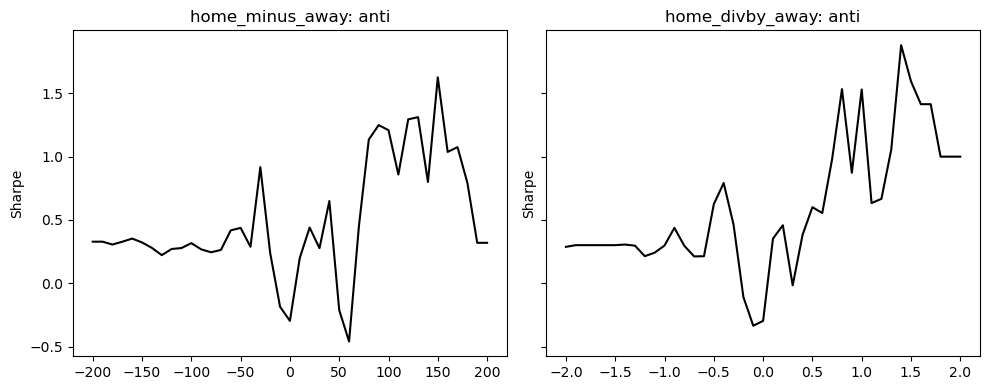

In [262]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
param_tune_plot_inplace(ax[0], "anti", 10, "home_minus_away")
param_tune_plot_inplace(ax[1], "anti", 0.1, "home_divby_away")
plt.tight_layout()
plt.show()

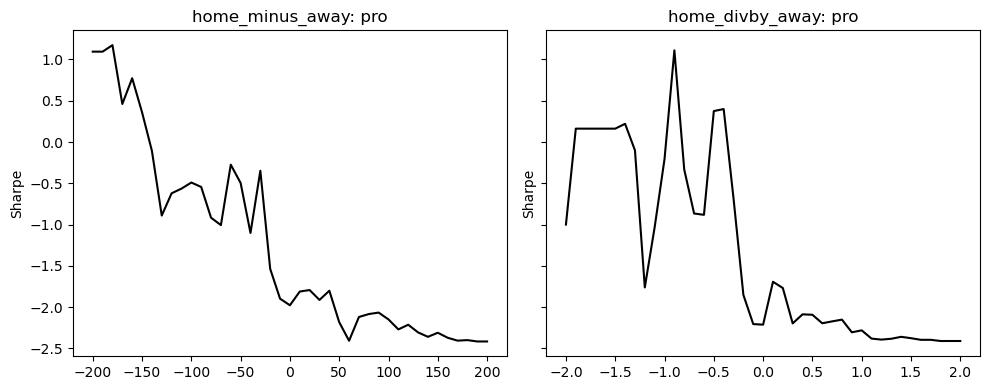

In [263]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
param_tune_plot_inplace(ax[0], "pro", 10, "home_minus_away")
param_tune_plot_inplace(ax[1], "pro", 0.1, "home_divby_away")
plt.tight_layout()
plt.show()

Summary: the pro-home side of the trade just isn't good - if you're betting against the home team you would do it when there is more betting on the away team, but there's never enough for it to be really worth doing. For the anti-home side of the trade, there's no meaningful distinction between taking a difference or a ratio. I'm going to go for the ratio approach, because it is probably easier to productionise: we're not looking at a list of all the trades that happened here. 

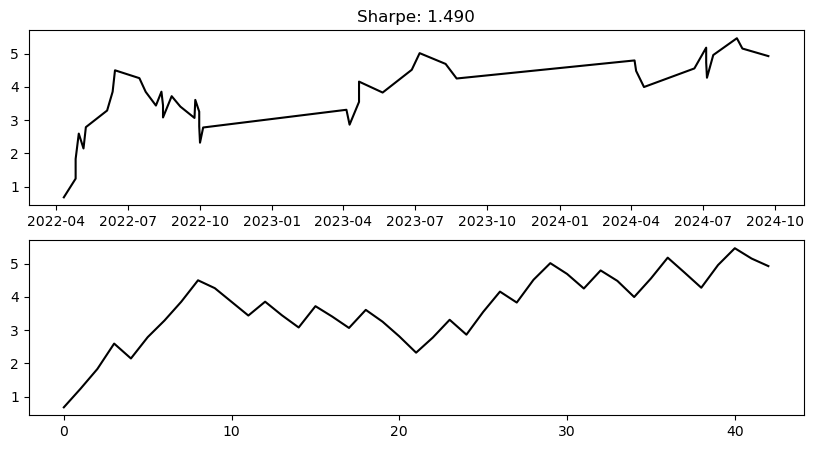

In [366]:
trade_rows = df[df["home_divby_away"] > 1].sort_values(by="date").dropna()
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
ax[0].plot(pd.to_datetime(trade_rows["date"]), trade_rows["anti_home_pnl"].cumsum(), color="black")
ax[0].set_title(f"Sharpe: {get_sharpe(trade_rows["anti_home_pnl"]):.3f}")
ax[1].plot(range(len(trade_rows)), trade_rows["anti_home_pnl"].cumsum(), color="black")
plt.show()

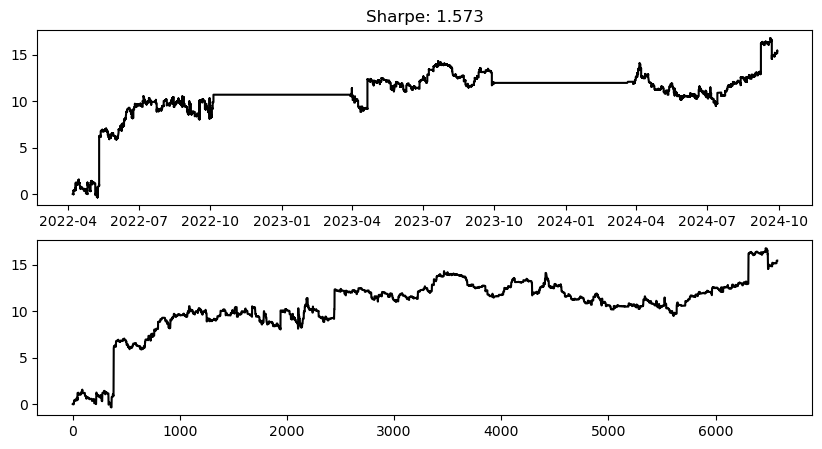

In [373]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))
pnl = df["anti_home_pnl"] * df["home_divby_away"].clip(lower=0) ** 3
ax[0].plot(pd.to_datetime(df["date"]), pnl.cumsum(), color="black")
ax[0].set_title(f"Sharpe: {get_sharpe(pnl):.3f}")
ax[1].plot(range(len(df)), pnl.cumsum(), color="black")
plt.show()

Not many trades.....

In [268]:
trade_rows["home"].value_counts()

home
Milwaukee Brewers        4
Tampa Bay Rays           3
Los Angeles Dodgers      3
St. Louis Cardinals      3
Houston Astros           3
San Francisco Giants     3
Chicago White Sox        3
Cleveland Guardians      3
San Diego Padres         2
Seattle Mariners         2
Texas Rangers            2
Minnesota Twins          2
Cincinnati Reds          2
Pittsburgh Pirates       1
Atlanta Braves           1
Miami Marlins            1
Toronto Blue Jays        1
Arizona Diamondbacks     1
Colorado Rockies         1
Kansas City Royals       1
Philadelphia Phillies    1
Name: count, dtype: int64

In [269]:
trade_rows["away"].value_counts()

away
Oakland Athletics       4
Chicago White Sox       4
Washington Nationals    4
Colorado Rockies        3
San Francisco Giants    3
Arizona Diamondbacks    3
Cleveland Guardians     2
Baltimore Orioles       2
San Diego Padres        2
Seattle Mariners        2
Boston Red Sox          2
Atlanta Braves          2
Kansas City Royals      2
Pittsburgh Pirates      1
Miami Marlins           1
Detroit Tigers          1
Chicago Cubs            1
Minnesota Twins         1
New York Mets           1
Tampa Bay Rays          1
Toronto Blue Jays       1
Name: count, dtype: int64

Looks like you're generally betting on small market teams against larger market teams. Let's check that out

In [270]:
market_size = pd.read_csv("refined_csvs/large_market.csv")
market_size_dict = dict(zip(market_size["full_name"], market_size["pop"]))

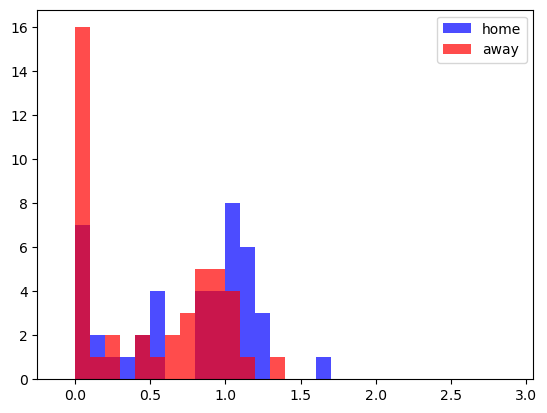

In [377]:
fig, ax = plt.subplots()
bins = np.arange(-0.1, 3, 0.1)
ax.hist(trade_rows["home_cli"].astype(float), bins=bins, color="blue", alpha=0.7)
ax.hist(trade_rows["away_cli"].astype(float), bins=bins, color="red", alpha=0.7)
ax.legend(["home", "away"])
plt.show()

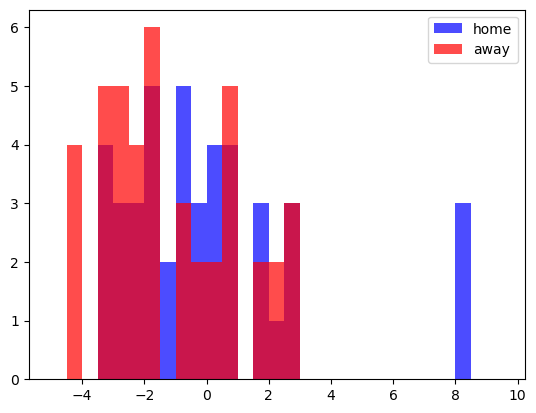

In [275]:
fig, ax = plt.subplots()
bins = np.arange(-5, 10, 0.5)
ax.hist(trade_rows["home"].map(market_size_dict), bins=bins, color="blue", alpha=0.7)
ax.hist(trade_rows["away"].map(market_size_dict), bins=bins, color="red", alpha=0.7)
ax.legend(["home", "away"])
plt.show()

Not smaller by much! 

In [280]:
mkt_size_diff = trade_rows["home"].map(market_size_dict) - trade_rows["away"].map(market_size_dict)
diffs = pd.Series([mkt_size_diff.sample(frac=1, replace=True).mean() for _ in range(10000)])
print(diffs.mean())
print((diffs > 0).mean())

1.1065138625467785
0.9865


So about a third of a stdev in popularity between who the teams. Maybe these differences just uhhh come about?